In [1]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, Lambda, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.datasets import mnist

from tensorflow.keras.layers import Activation

In [2]:
import tensorflow as tf
gpu_num = 2
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU만 사용하도록 제한
  try:
    tf.config.experimental.set_visible_devices(gpus[gpu_num], 'GPU')
    tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
  except RuntimeError as e:
    # 프로그램 시작시에 접근 가능한 장치가 설정되어야만 합니다
    print(e)
    
from tensorflow.keras.mixed_precision.experimental import Policy
policy = Policy('mixed_float16')
tf.keras.mixed_precision.experimental.set_policy(policy)
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPUs will likely run quickly with dtype policy mixed_float16 as they all have compute capability of at least 7.0
Compute dtype: float16
Variable dtype: float32


In [3]:
# 주요 변수 정의하기
batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0

In [6]:
@tf.function
def sampling(args: tuple):
    # 튜플로 매개변수를 감쌉니다.
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std, dtype='float16')
    #_return = Activation('linear',dtype='float32')(z_mean + K.exp(z_log_var / 2) * epsilon)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# 인코더 정의하기

In [7]:
# 인코더 입력
x = Input(shape=(original_dim,), name="input")
# 중간 층
h = Dense(intermediate_dim, activation='relu', name="encoding")(x)
# 잠재 공간의 평균을 정의합니다.
_z_mean = Dense(latent_dim, name="mean")(h)
z_mean = Activation('linear',dtype='float32')(_z_mean)
# 잠재 공간의 로그 분산을 정의합니다.
_z_log_var = Dense(latent_dim, name="log-variance")(h)
z_log_var = Activation('linear',dtype='float32')(_z_log_var)
# 텐서플로 백엔드를 사용할 때는 output_shape이 꼭 필요한 것은 아닙니다.
_z = Lambda(sampling, output_shape=(latent_dim,))([_z_mean, _z_log_var])
z = Activation('linear',dtype='float32')(_z)
# 케라스 모델로 인코더를 정의합니다.
encoder = Model(x, [z_mean, z_log_var, z], name="encoder")
# 인코더 구조를 출력합니다.
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 784)]        0                                            
__________________________________________________________________________________________________
encoding (Dense)                (None, 256)          200960      input[0][0]                      
__________________________________________________________________________________________________
mean (Dense)                    (None, 2)            514         encoding[0][0]                   
__________________________________________________________________________________________________
log-variance (Dense)            (None, 2)            514         encoding[0][0]                   
____________________________________________________________________________________________

# 디코더 정의하기

In [39]:
# 다코더 입력
input_decoder = Input(shape=(latent_dim,), name="decoder_input")
# 잠재 공간을 중간 층의 차원으로 변환하기
decoder_h = Dense(intermediate_dim, activation='relu', name="decoder_h")(input_decoder)
# getting the mean from the original dimension
x_decoded = Dense(original_dim, activation='sigmoid', name="flat_decoded")(decoder_h)
x_decoded = Activation('linear',dtype='float32')(x_decoded)
# 케라스 모델로 디코더를 정의합니다.
decoder = Model(input_decoder, x_decoded, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
decoder_h (Dense)            (None, 256)               768       
_________________________________________________________________
flat_decoded (Dense)         (None, 784)               201488    
_________________________________________________________________
activation_6 (Activation)    (None, 784)               0         
Total params: 202,256
Trainable params: 202,256
Non-trainable params: 0
_________________________________________________________________


## 변이형 오토인코더(VAE) 정의하기

위에서 정의한 인코더와 디코더 객체를 사용합니다.

In [9]:
# 인코더의 출력을 디코더에 사용합니다. 인코더의 3번째 반환 값이 z입니다.
output_combined = decoder(encoder(x)[2])
# 입력과 출력을 연결합니다.
vae = Model(x, output_combined)
# 모델 구조를 출력합니다.
vae.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
encoder (Functional)         [(None, 2), (None, 2), (N 201988    
_________________________________________________________________
decoder (Functional)         (None, 784)               202256    
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


In [11]:
kl_loss = -0.5 * K.sum(
    1 + z_log_var - K.exp(z_log_var) - K.square(z_mean),
    axis=-1)

vae.add_loss(K.mean(kl_loss) / 784.)
vae.compile(optimizer='rmsprop', loss="binary_crossentropy")
vae.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 784)]        0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 2), (None, 2 201988      input[0][0]                      
__________________________________________________________________________________________________
decoder (Functional)            (None, 784)          202256      encoder[0][2]                    
__________________________________________________________________________________________________
encoding (Dense)                (None, 256)          200960      input[0][0]                      
_______________________________________________________________________________________

In [12]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [13]:
vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size)

Epoch 1/50
600/600 [==============================] - 4s 7ms/step - loss: 0.2426
Epoch 2/50
600/600 [==============================] - 4s 7ms/step - loss: 0.2165
Epoch 3/50
600/600 [==============================] - 4s 7ms/step - loss: 0.2124
Epoch 4/50
600/600 [==============================] - 4s 7ms/step - loss: 0.2097
Epoch 5/50
600/600 [==============================] - 4s 7ms/step - loss: 0.2078
Epoch 6/50
600/600 [==============================] - 4s 7ms/step - loss: 0.2063
Epoch 7/50
600/600 [==============================] - 4s 7ms/step - loss: 0.2050
Epoch 8/50
600/600 [==============================] - 4s 7ms/step - loss: 0.2038
Epoch 9/50
600/600 [==============================] - 4s 7ms/step - loss: 0.2027
Epoch 10/50
600/600 [==============================] - 4s 7ms/step - loss: 0.2016
Epoch 11/50
600/600 [==============================] - 4s 7ms/step - loss: 0.2007
Epoch 12/50
600/600 [==============================] - 4s 7ms/step - loss: 0.1999
Epoch 13/50
600/600 [====

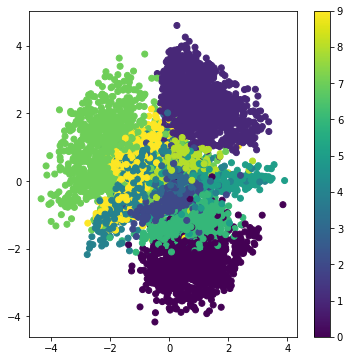

In [14]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)[0]
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=y_test, cmap='viridis')
plt.colorbar()
plt.show()

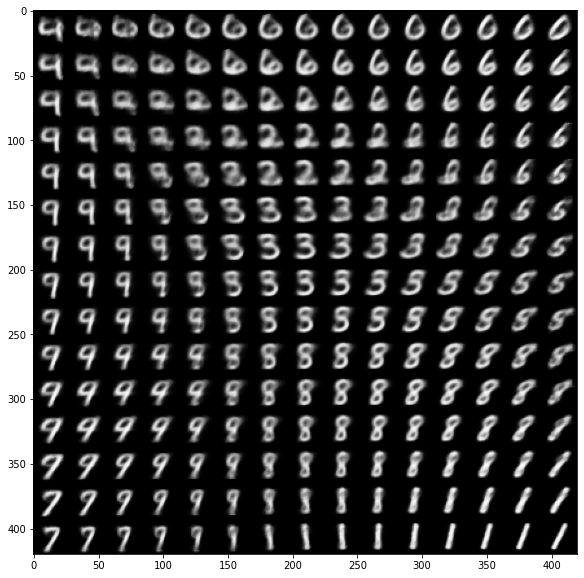

In [15]:
# 숫자의 2D 매니폴드 출력하기
n = 15  # 15x15 숫자를 담은 그림
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

In [17]:
grid_x

array([-1.64485363e+00, -1.20404696e+00, -9.20822976e-01, -6.97141435e-01,
       -5.03965367e-01, -3.28072108e-01, -1.61844167e-01, -1.39145821e-16,
        1.61844167e-01,  3.28072108e-01,  5.03965367e-01,  6.97141435e-01,
        9.20822976e-01,  1.20404696e+00,  1.64485363e+00])

In [19]:
digit.shape

(28, 28)

In [36]:
decoder.predict(z_sample).squeeze().shape

(784,)